In [1]:
import numpy as np

In [2]:
point_cloud_dict = np.load('./saved_obj/PointCloud_dict_test.npy', allow_pickle=True).item()

In [3]:
point_cloud_dict

{'office1': array([[2.5     , 2.25    , 2.6     ],
        [2.5     , 2.375   , 2.6     ],
        [2.5     , 2.45    , 2.6     ],
        ...,
        [3.825   , 1.733333, 0.7     ],
        [0.925   , 2.875   , 0.05    ],
        [1.495   , 1.278333, 0.53    ]], dtype=float32),
 'office10': array([[3.      , 2.5     , 2.6     ],
        [3.      , 2.625   , 2.6     ],
        [3.      , 2.7     , 2.6     ],
        ...,
        [3.9725  , 2.275   , 0.7     ],
        [3.065   , 4.078333, 0.48    ],
        [1.485   , 2.533333, 0.7     ]], dtype=float32),
 'office11': array([[3.       , 2.5      , 2.6      ],
        [3.       , 2.625    , 2.6      ],
        [3.       , 2.7      , 2.6      ],
        ...,
        [3.96     , 4.305    , 0.53     ],
        [3.45     , 3.183333 , 0.75     ],
        [2.7      , 5.1      , 0.2833333]], dtype=float32),
 'office12': array([[3.      , 2.5     , 2.6     ],
        [3.      , 2.625   , 2.6     ],
        [3.      , 2.7     , 2.6     ],
     

In [4]:
point_cloud_list = []
for i in range(33):
    if i==29:
        continue
    point_cloud_list.append(point_cloud_dict[f'office{i+1}'])

point_cloud_array = np.array(point_cloud_list)

point_cloud_array.shape

(32, 2048, 3)

In [5]:
point_cloud_array_reshape = point_cloud_array.reshape(-1,3)
point_cloud_array_reshape.shape

(65536, 3)

In [6]:
x_mean = []
x_std = []

for i in range(3):
    x_mean.append(np.mean(point_cloud_array_reshape[:,i]))
    x_std.append(np.std(point_cloud_array_reshape[:,i], ddof=0))

In [7]:
print(x_mean)
print(x_std)

[4.060322, 2.6875114, 1.2308416]
[1.9615167, 1.2216018, 0.92776775]


In [8]:
# officeモデルのみで標準化定義

def standardization(array:np.array, x_mean, x_std):
    array_std = array.copy()
    for i in range(3):
        array_std[:,i] = (array[:,i] - x_mean[i]) / x_std[i]
    return array_std

scanデータ読み込み

In [9]:
import open3d as o3d
import matplotlib.pyplot as plt

NUM_POINTS = 2048

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
def plot3d_points(point_cloud):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], alpha=1.0, s=1)
    ax.set_aspect('equal')
    # ax.set_axis_off()
    plt.show()

In [12]:
scan_points = []

for i in range(6):
    mesh_full = o3d.io.read_triangle_mesh(f'./stl/scan_{i+1}_edit.stl')
    mesh_inside = o3d.io.read_triangle_mesh(f'./stl/scan_{i+1}_trim.stl')

    point_cloud = mesh_full.sample_points_poisson_disk(number_of_points=10000)
    points_for_corners = np.array(point_cloud.points)

    x_min = min(points_for_corners[:,0])
    x_max = max(points_for_corners[:,0])
    y_min = min(points_for_corners[:,1])
    y_max = max(points_for_corners[:,1])
    z_min = min(points_for_corners[:,2])
    z_max = max(points_for_corners[:,2])

    # print(x_min, x_max, y_min, y_max, z_min, z_max)

    corner_1 = np.array([[x_min, y_min, z_min]])
    corner_2 = np.array([[x_max, y_min, z_min]])
    corner_3 = np.array([[x_min, y_max, z_min]])
    corner_4 = np.array([[x_max, y_max, z_min]])
    corner_5 = np.array([[x_min, y_min, z_max]])
    corner_6 = np.array([[x_max, y_min, z_max]])
    corner_7 = np.array([[x_min, y_max, z_max]])
    corner_8 = np.array([[x_max, y_max, z_max]])

    corner_points = np.concatenate([corner_1, corner_2, corner_3, corner_4, corner_5, corner_6, corner_7, corner_8], axis=0)

    point_cloud = mesh_inside.sample_points_poisson_disk(number_of_points=NUM_POINTS-8)
    inside_points = np.array(point_cloud.points)

    points = np.concatenate([corner_points, inside_points], axis=0)

    # 平行移動
    # points[:, 0] = points[:, 0] - (x_max - x_min) / 2
    # points[:, 1] = points[:, 1] - (y_max - y_min) / 2
    # points[:, 2] = points[:, 2] - (z_max - z_min) / 2

    scan_points.append(points)

scan_points = np.array(scan_points)

In [11]:
# 読み込む場合
scan_points = np.load('./saved_obj/scan_points.npy')

In [13]:
# 点群保存
# np.save('./saved_obj/scan_points.npy', scan_points)

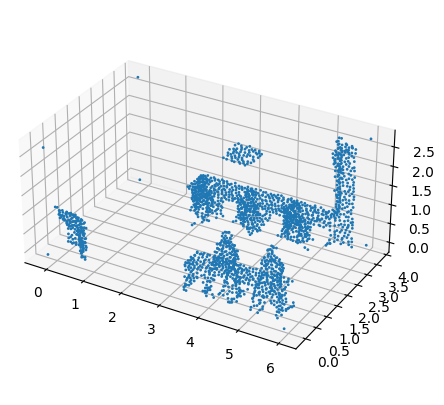

In [12]:
plot3d_points(scan_points[0])

In [13]:
# 標準化
scan_points_std = []
for i in range(scan_points.shape[0]):
    scan_points_std.append(standardization(scan_points[i], x_mean, x_std))

scan_points_std = np.array(scan_points_std)

In [14]:
scan_points_std[0,0]

array([-2.14304967, -2.32789685, -1.38975314])

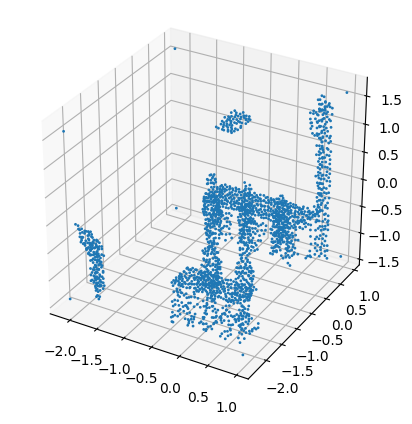

In [15]:
plot3d_points(scan_points_std[0])

空調条件データと合わせる

In [16]:
meta_array = np.load('./saved_obj/meta_array.npy', allow_pickle=True)

In [17]:
X_dict_list = []

for i in range(6):
    point_cloud_list = []
    for j in range(meta_array.shape[0]):
        point_cloud_list.append(scan_points_std[i])

    X_dict = {}
    X_dict['meta'] = meta_array
    X_dict['pointCloud'] = np.array(point_cloud_list)

    X_dict_list.append(X_dict)

In [18]:
X_dict_list[0]

{'meta': array([[-1.38775264, -1.66542468, -0.86853442, -0.86853442,  2.47825186],
        [-1.38775264,  0.28240277,  1.15136485, -0.86853442, -0.40351024],
        [-1.38775264,  0.28240277, -0.86853442,  1.15136485, -0.40351024],
        [-1.38775264,  1.25631649,  1.15136485, -0.86853442, -0.40351024],
        [-1.38775264,  1.25631649, -0.86853442,  1.15136485, -0.40351024],
        [-1.38775264, -0.69151096,  1.15136485, -0.86853442, -0.40351024],
        [-1.38775264, -0.69151096, -0.86853442,  1.15136485, -0.40351024],
        [-0.38240787, -1.66542468, -0.86853442, -0.86853442,  2.47825186],
        [-0.38240787,  0.28240277,  1.15136485, -0.86853442, -0.40351024],
        [-0.38240787,  0.28240277, -0.86853442,  1.15136485, -0.40351024],
        [-0.38240787,  1.25631649,  1.15136485, -0.86853442, -0.40351024],
        [-0.38240787,  1.25631649, -0.86853442,  1.15136485, -0.40351024],
        [-0.38240787, -0.69151096,  1.15136485, -0.86853442, -0.40351024],
        [-0.38240

モデルに入力

In [19]:
import keras

In [20]:
model_str = open('./saved_obj/best_model.json').read()
model = keras.models.model_from_json(model_str)
model.load_weights('./saved_obj/best_weights.hdf5')

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.006781976583074642), # learning_rateにoptunaの探索結果を直接代入
        loss='mse',
        metrics=['mae'],
        )

model.summary()

Model: "predictionnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pointCloud (InputLayer)        [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['pointCloud[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization

In [21]:
y_pred_list = []

for i in range(6):
    y_pred = model.predict(X_dict_list[i])
    y_pred_list.append(y_pred.reshape((y_pred.shape[0])))

1/1 [==============================] - 0s 36ms/step


結果プロット

In [22]:
import pandas as pd
import re

In [23]:
df_all = pd.read_csv('./saved_obj/summary_20230112.csv')
df_all['plot_num'] = 0
for i in range(df_all.shape[0]):
    df_all.iloc[i, -1] = i

y_all = np.array(df_all['countTimeMean_onlyFloating'].values)

office_num_array = df_all['office'].values
office_num = []
for office in office_num_array:
    office_num.append(int(re.findall(r'\d+', office)[0]))

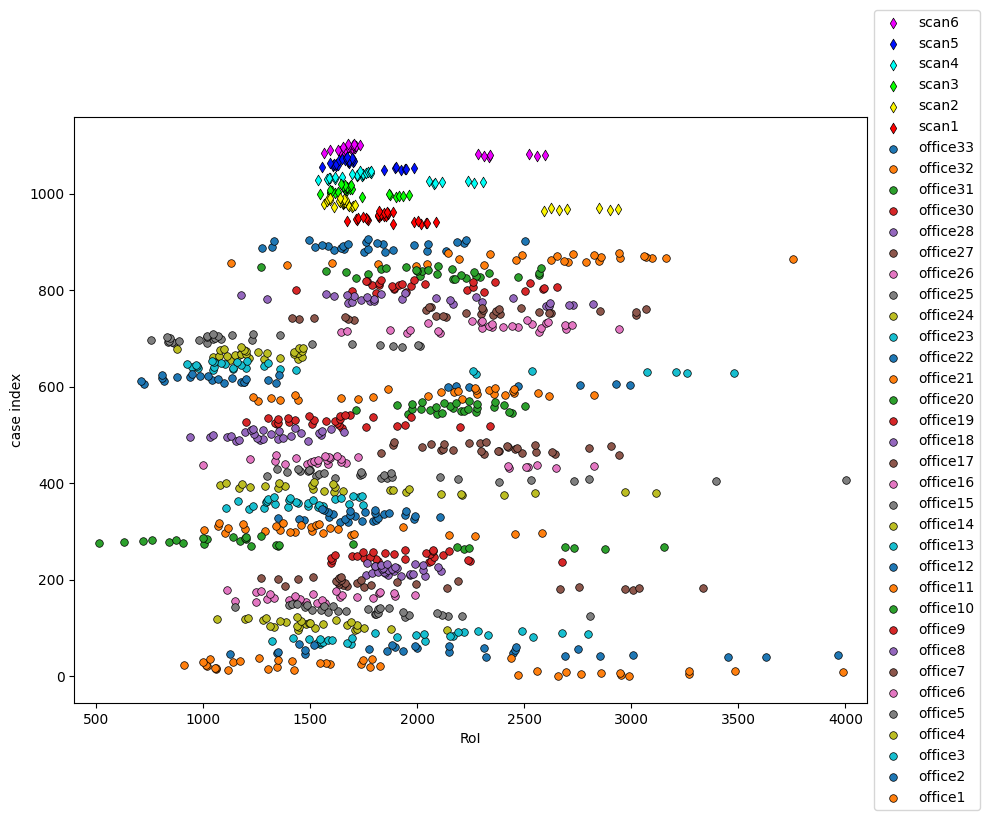

In [24]:
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('hsv')

space = 30

for i in reversed(range(6)):
    plot_num_start = df_all.iloc[-1, -1] + space + 1 + meta_array.shape[0] * i
    plot_num_end = df_all.iloc[-1, -1] + space + meta_array.shape[0] * (i + 1)
    plot_num = list(range(plot_num_start, plot_num_end+1))
    data = y_pred_list[i]

    plt.scatter(data, plot_num, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

cmap = plt.get_cmap('tab10')

for i, office in enumerate(reversed(list(set(office_num)))):
    idx = np.where(np.array(office_num)==office)
    data = y_all[idx]
    plot_num = df_all.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), edgecolor='k', linewidth=0.5, s=30, label=f'office{office}')

plt.xlim(400, 4100)
plt.xlabel('RoI')
plt.ylabel('case index')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

In [25]:
X_dict_fit = np.load('./saved_obj/X_dict_fit.npy', allow_pickle=True).item()
X_dict_test = np.load('./saved_obj/X_dict_test.npy', allow_pickle=True).item()

In [26]:
pred_y_fit = model.predict(X_dict_fit)
pred_y_test = model.predict(X_dict_test)

3/3 [==============================] - 0s 27ms/step


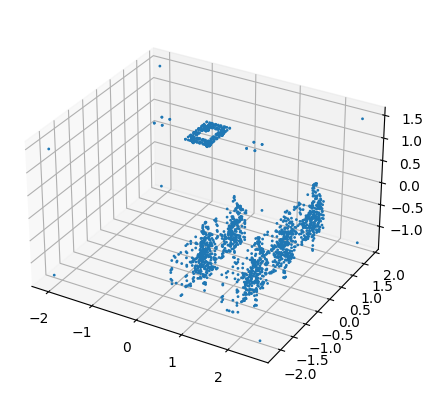

In [27]:
plot3d_points(X_dict_fit['pointCloud'][500])

In [28]:
df_fit = pd.read_csv('./saved_obj/df_fit.csv')
df_test = pd.read_csv('./saved_obj/df_test.csv')

df_fit['plot_num'] = 0
for i in range(df_fit.shape[0]):
    df_fit.iloc[i, -1] = df_all[df_all['case_name']==df_fit.iloc[i, 0]].index

df_test['plot_num'] = 0
for i in range(df_test.shape[0]):
    df_test.iloc[i, -1] = df_all[df_all['case_name']==df_test.iloc[i, 0]].index

office_fit_num_array = df_fit['office'].values
office_fit_num = []
for office in office_fit_num_array:
    office_fit_num.append(int(re.findall(r'\d+', office)[0]))

office_test_num_array = df_test['office'].values
office_test_num = []
for office in office_test_num_array:
    office_test_num.append(int(re.findall(r'\d+', office)[0]))

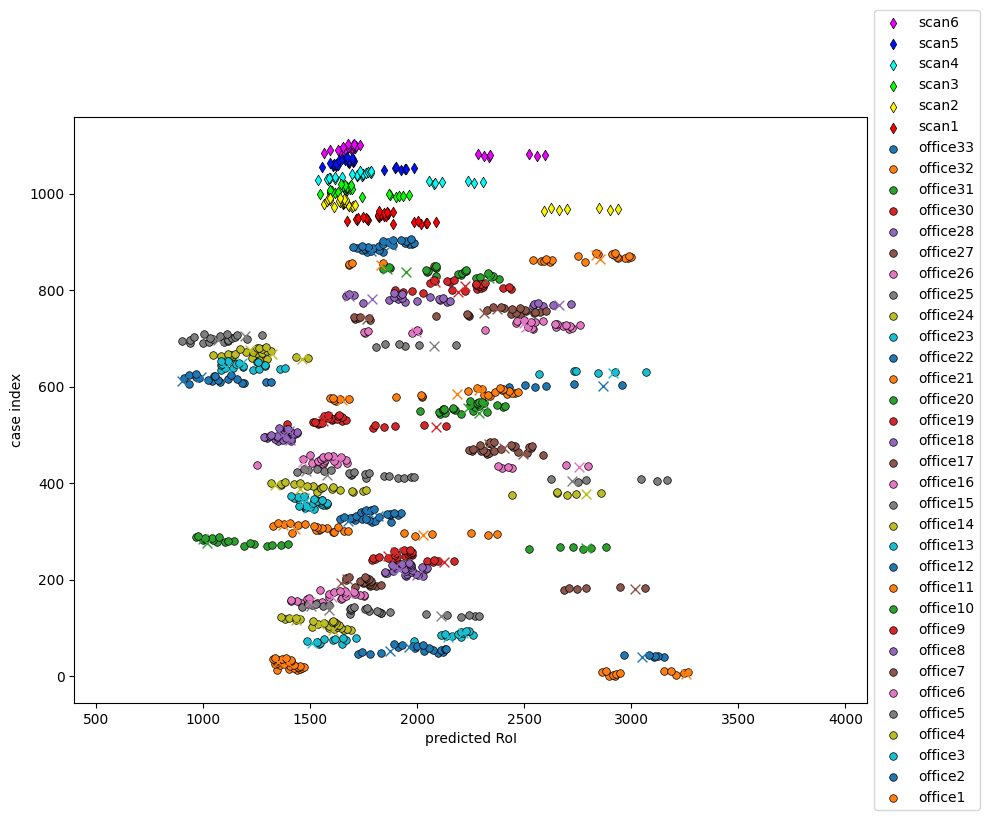

In [29]:
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('hsv')

space = 30

for i in reversed(range(6)):
    plot_num_start = df_all.iloc[-1, -1] + space + 1 + meta_array.shape[0] * i
    plot_num_end = df_all.iloc[-1, -1] + space + meta_array.shape[0] * (i + 1)
    plot_num = list(range(plot_num_start, plot_num_end+1))
    data = y_pred_list[i]

    plt.scatter(data, plot_num, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

cmap = plt.get_cmap('tab10')

for i, office in enumerate(reversed(list(set(office_fit_num)))):
    idx = np.where(np.array(office_fit_num)==office)
    data = pred_y_fit[idx]
    plot_num = df_fit.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), edgecolor='k', lw=0.5, s=30, label=f'office{office}')

for i, office in enumerate(reversed(list(set(office_test_num)))):
    idx = np.where(np.array(office_test_num)==office)
    data = pred_y_test[idx]
    plot_num = df_test.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), lw=1, s=50, marker='x')

plt.xlim(400, 4100)
plt.xlabel('predicted RoI')
plt.ylabel('case index')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

officeのstlで作成したscan1をPointNetに入力

In [116]:
# stl読み込み
mesh1 = o3d.io.read_triangle_mesh(f'./scan1_complete/aircon_body.stl')
mesh2 = o3d.io.read_triangle_mesh(f'./scan1_complete/aircon_inlets.stl')
mesh3 = o3d.io.read_triangle_mesh(f'./scan1_complete/aircon_outlet.stl')
mesh4 = o3d.io.read_triangle_mesh(f'./scan1_complete/airvent_a.stl')
mesh5 = o3d.io.read_triangle_mesh(f'./scan1_complete/airvent_b.stl')
mesh6 = o3d.io.read_triangle_mesh(f'./scan1_complete/bodies.stl')
mesh7 = o3d.io.read_triangle_mesh(f'./scan1_complete/desks.stl')
mesh8 = o3d.io.read_triangle_mesh(f'./scan1_complete/pillar.stl')
mesh9 = o3d.io.read_triangle_mesh(f'./scan1_complete/washstand.stl')

mesh = mesh1 + mesh2 + mesh3 + mesh4 + mesh5 + mesh6 + mesh7 + mesh8 + mesh9

x_min = 0
x_max = 5.8
y_min = 0
y_max = 3.8
z_min = 0
z_max = 2.6

corner_1 = np.array([[x_min, y_min, z_min]])
corner_2 = np.array([[x_max, y_min, z_min]])
corner_3 = np.array([[x_min, y_max, z_min]])
corner_4 = np.array([[x_max, y_max, z_min]])
corner_5 = np.array([[x_min, y_min, z_max]])
corner_6 = np.array([[x_max, y_min, z_max]])
corner_7 = np.array([[x_min, y_max, z_max]])
corner_8 = np.array([[x_max, y_max, z_max]])

corner_points = np.concatenate([corner_1, corner_2, corner_3, corner_4, corner_5, corner_6, corner_7, corner_8], axis=0)

point_cloud = mesh.sample_points_poisson_disk(number_of_points=NUM_POINTS-8)
inside_points = np.array(point_cloud.points)

points = np.concatenate([corner_points, inside_points], axis=0)

# 平行移動
# points[:, 0] = points[:, 0] - (x_max - x_min) / 2
# points[:, 1] = points[:, 1] - (y_max - y_min) / 2
# points[:, 2] = points[:, 2] - (z_max - z_min) / 2

scan1_points = points

In [30]:
# 読み込む場合
scan1_points = np.load('./saved_obj/scan1_points.npy')

In [31]:
# 標準化
scan1_points_std = standardization(scan1_points, x_mean, x_std)

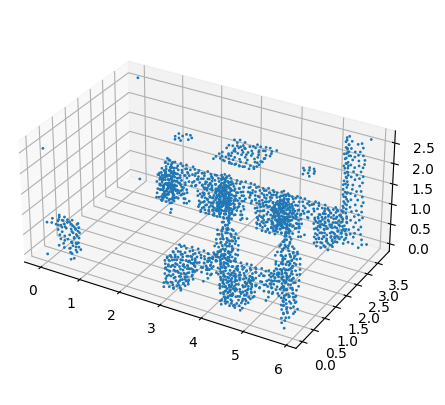

In [32]:
plot3d_points(scan1_points)

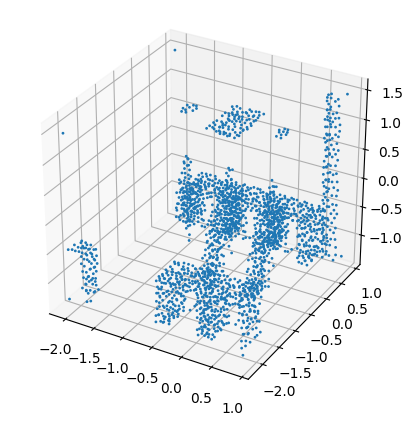

In [33]:
plot3d_points(scan1_points_std)

In [34]:
meta_array = np.load('./saved_obj/meta_array.npy', allow_pickle=True)

point_cloud_list = []
for i in range(meta_array.shape[0]):
    point_cloud_list.append(scan1_points_std)

scan1_X_dict = {}
scan1_X_dict['meta'] = meta_array
scan1_X_dict['pointCloud'] = np.array(point_cloud_list)

In [35]:
scan1_pred = model.predict(scan1_X_dict)

1/1 [==============================] - 0s 33ms/step


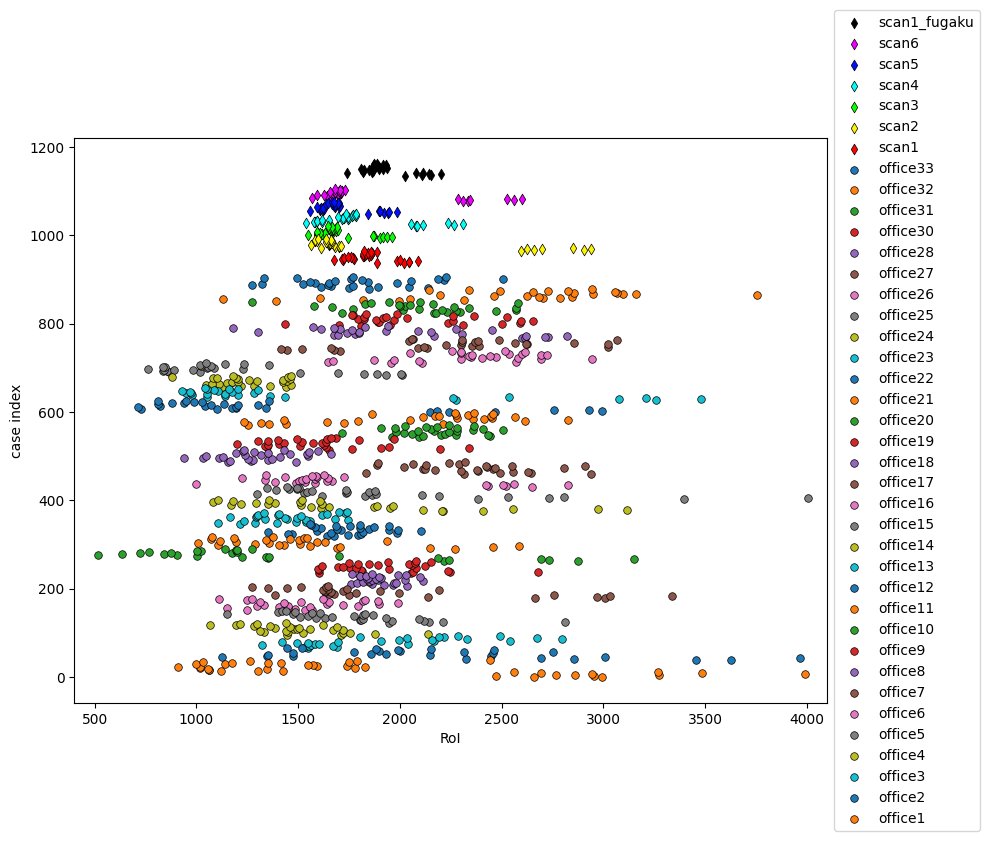

In [36]:
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('hsv')

space = 30

plot_num_start = df_all.iloc[-1, -1] + space * 2 + 1 + meta_array.shape[0] * 6
plot_num_end = df_all.iloc[-1, -1] + space * 2 + meta_array.shape[0] * 7
plot_num = list(range(plot_num_start, plot_num_end+1))
data = scan1_pred

plt.scatter(data, plot_num, marker='d', color='k', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_fugaku')

for i in reversed(range(6)):
    plot_num_start = df_all.iloc[-1, -1] + space + 1 + meta_array.shape[0] * i
    plot_num_end = df_all.iloc[-1, -1] + space + meta_array.shape[0] * (i + 1)
    plot_num = list(range(plot_num_start, plot_num_end+1))
    data = y_pred_list[i]

    plt.scatter(data, plot_num, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

cmap = plt.get_cmap('tab10')

for i, office in enumerate(reversed(list(set(office_num)))):
    idx = np.where(np.array(office_num)==office)
    data = y_all[idx]
    plot_num = df_all.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), edgecolor='k', linewidth=0.5, s=30, label=f'office{office}')

plt.xlim(400, 4100)
plt.xlabel('RoI')
plt.ylabel('case index')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

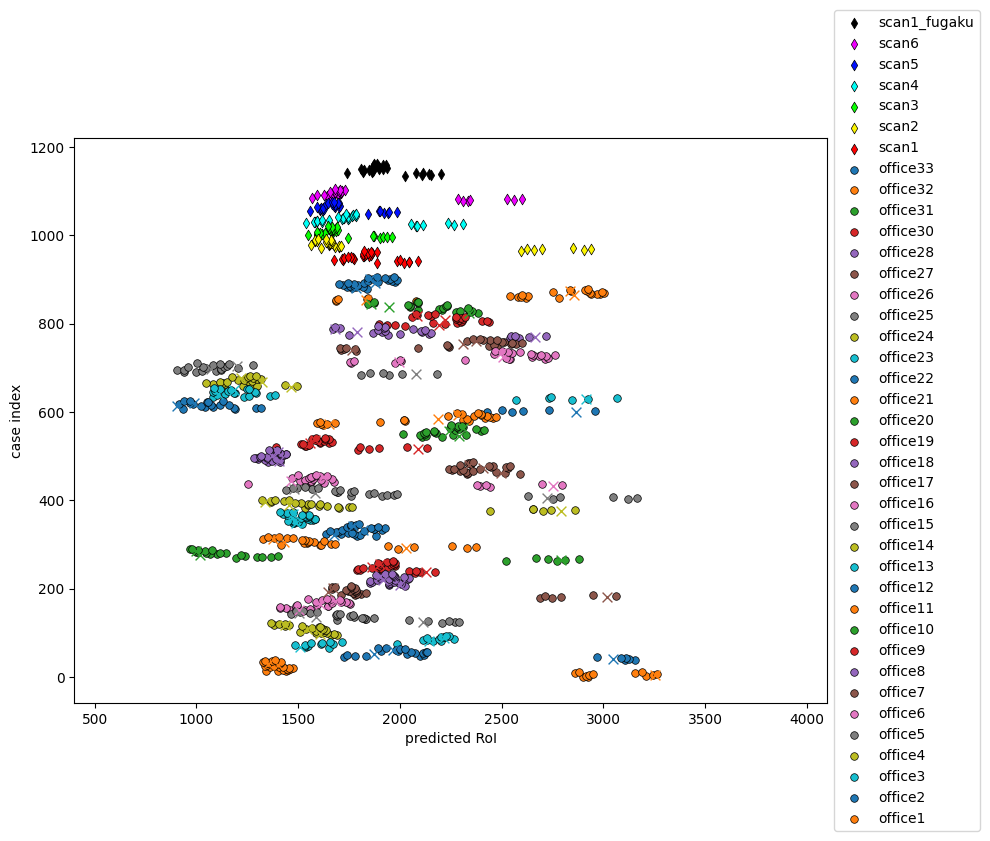

In [37]:
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('hsv')

space = 30

plot_num_start = df_all.iloc[-1, -1] + space * 2 + 1 + meta_array.shape[0] * 6
plot_num_end = df_all.iloc[-1, -1] + space * 2 + meta_array.shape[0] * 7
plot_num = list(range(plot_num_start, plot_num_end+1))
data = scan1_pred

plt.scatter(data, plot_num, marker='d', color='k', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_fugaku')

for i in reversed(range(6)):
    plot_num_start = df_all.iloc[-1, -1] + space + 1 + meta_array.shape[0] * i
    plot_num_end = df_all.iloc[-1, -1] + space + meta_array.shape[0] * (i + 1)
    plot_num = list(range(plot_num_start, plot_num_end+1))
    data = y_pred_list[i]

    plt.scatter(data, plot_num, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

cmap = plt.get_cmap('tab10')

for i, office in enumerate(reversed(list(set(office_fit_num)))):
    idx = np.where(np.array(office_fit_num)==office)
    data = pred_y_fit[idx]
    plot_num = df_fit.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), edgecolor='k', lw=0.5, s=30, label=f'office{office}')

for i, office in enumerate(reversed(list(set(office_test_num)))):
    idx = np.where(np.array(office_test_num)==office)
    data = pred_y_test[idx]
    plot_num = df_test.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), lw=1, s=50, marker='x')

plt.xlim(400, 4100)
plt.xlabel('predicted RoI')
plt.ylabel('case index')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

新モデル

In [38]:
y_pred = np.load('./saved_obj/scan1_y_pred.npy')

In [39]:
df_scan1 = pd.read_csv('./summary_scan1.csv')['countTimeMean_onlyFloating']
df_scan1

0     1757.936667
1     1869.638333
2     1362.842000
3     1542.956667
4     1825.899000
5     1967.014333
6     1744.621000
7     1650.899000
8     1652.457667
9     1659.433667
10    1854.167333
11    1379.586000
12    1261.606000
13    1695.728333
14    1892.099333
15    1560.642000
16    1971.424000
17    1861.647667
18    2054.722333
19    1616.761667
20    1761.233333
21    2053.385333
22    2244.822333
23    1852.020000
24    1825.473333
25    1924.897333
26    1738.178667
27    2063.413000
Name: countTimeMean_onlyFloating, dtype: float64

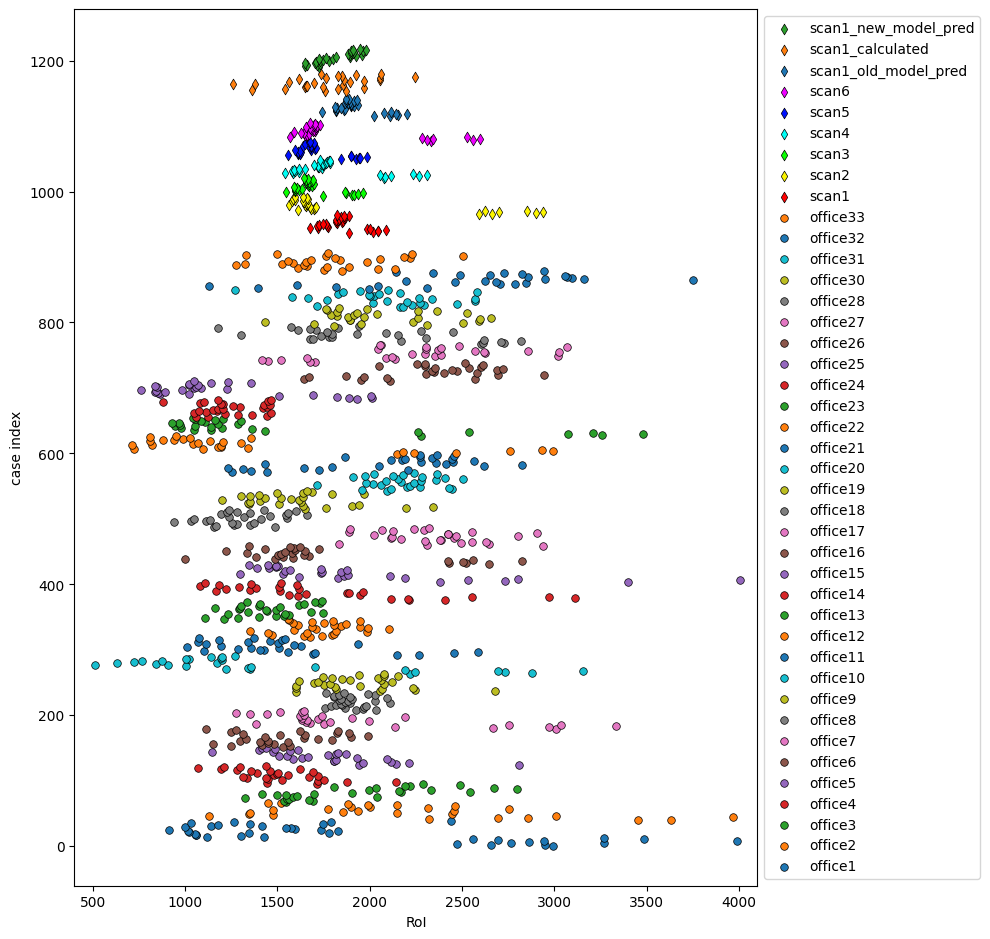

In [40]:
plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('tab10')
ye = 0
for i, office in enumerate(list(set(office_num))):
    idx = np.where(np.array(office_num)==office)
    data = y_all[idx]
    ys = ye
    ye += data.shape[0]
    y = list(range(ys, ye))
    plt.scatter(data, y, color=cmap((i%10)/10), edgecolor='k', linewidth=0.5, s=30, label=f'office{office}')

ye += 30

cmap = plt.get_cmap('hsv')
for i in range(6):
    data = y_pred_list[i]
    ys = ye
    ye += data.shape[0]
    y = list(range(ys, ye))
    plt.scatter(data, y, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

ye += 10

data = scan1_pred
ys = ye
ye += data.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_old_model_pred')

ye += 10

data = df_scan1
ys = ye
ye += data.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_calculated')

ye += 10

data = y_pred
ys = ye
ye += y_pred.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_new_model_pred')


plt.xlim(400, 4100)
plt.xlabel('RoI')
plt.ylabel('case index')
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

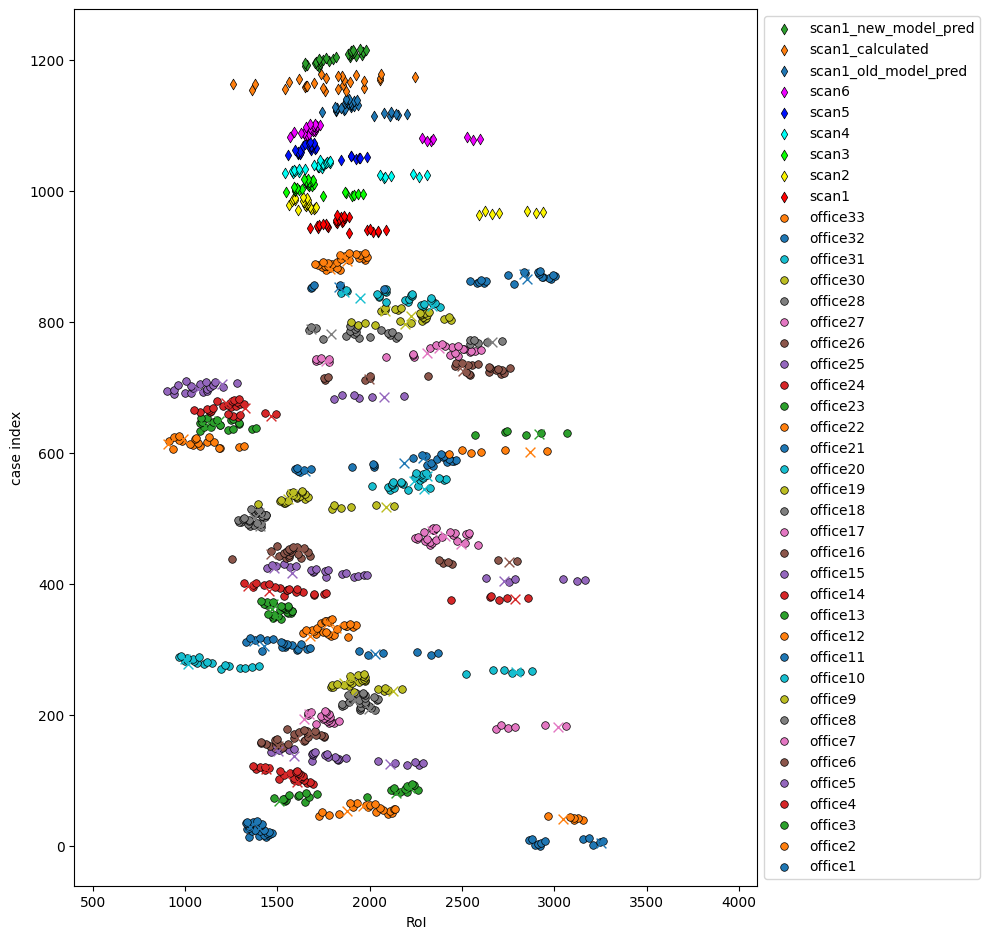

In [41]:
plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('tab10')
ye = 0
for i, office in enumerate(list(set(office_fit_num))):
    idx = np.where(np.array(office_fit_num)==office)
    data = pred_y_fit[idx]
    plot_num = df_fit.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), edgecolor='k', lw=0.5, s=30, label=f'office{office}')

ye += np.max(plot_num) + 30

for i, office in enumerate(list(set(office_test_num))):
    idx = np.where(np.array(office_test_num)==office)
    data = pred_y_test[idx]
    plot_num = df_test.loc[idx]['plot_num']

    plt.scatter(data, plot_num, color=cmap((i%10)/10), lw=1, s=50, marker='x')

cmap = plt.get_cmap('hsv')
for i in range(6):
    data = y_pred_list[i]
    ys = ye
    ye += data.shape[0]
    y = list(range(ys, ye))
    plt.scatter(data, y, marker='d', color=cmap(i/6), edgecolor='k', linewidth=0.5, s=30, label=f'scan{i+1}')

ye += 10

data = scan1_pred
ys = ye
ye += data.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_old_model_pred')

ye += 10

data = df_scan1
ys = ye
ye += data.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_calculated')

ye += 10

data = y_pred
ys = ye
ye += y_pred.shape[0]
y = list(range(ys, ye))
plt.scatter(data, y, marker='d', edgecolor='k', linewidth=0.5, s=30, label=f'scan1_new_model_pred')


plt.xlim(400, 4100)
plt.xlabel('RoI')
plt.ylabel('case index')
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

空調条件対応関係

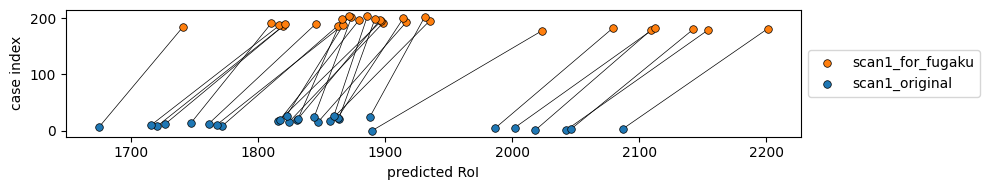

In [63]:
plt.figure(figsize=(10, 2))

case_space = 150
data_size = scan1_pred.shape[0]

x1 = y_pred_list[0]
x2 = scan1_pred[:,0]
y1 = list(range(data_size))
ys = np.max(y1) + case_space
y2 = list(range(ys, ys+data_size))

# 空調条件対応関係プロット
space = case_space + data_size - 1
for i in range(data_size):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], c='k', lw=0.5, zorder=1)

# RoIプロット
plt.scatter(x1, y1, marker='o', s=30, edgecolor='k', linewidth=0.5, label=f'scan1_original', zorder=2)
plt.scatter(x2, y2, marker='o', s=30, edgecolor='k', linewidth=0.5, label=f'scan1_for_fugaku', zorder=2)

plt.xlabel('predicted RoI')
plt.ylabel('case index')
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

新モデルでプロット

In [64]:
# 学習済モデルを読み込む場合

model_str = open('./saved_obj/best_model.json').read()
new_model = keras.models.model_from_json(model_str)
new_model.load_weights('./saved_obj/concat_scan_model/plus_scan1_weights_202307041515.hdf5')

new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.006781976583074642), # learning_rateにoptunaの探索結果を直接代入
        loss='mse',
        metrics=['mae'],
        )

new_model.summary()

Model: "predictionnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pointCloud (InputLayer)        [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['pointCloud[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization

In [65]:
new_y_pred_list = []

for i in range(6):
    tmp = new_model.predict(X_dict_list[i])
    new_y_pred_list.append(tmp.reshape((tmp.shape[0])))

1/1 [==============================] - 0s 36ms/step


In [66]:
new_scan1_pred = new_model.predict(scan1_X_dict)

1/1 [==============================] - 0s 35ms/step


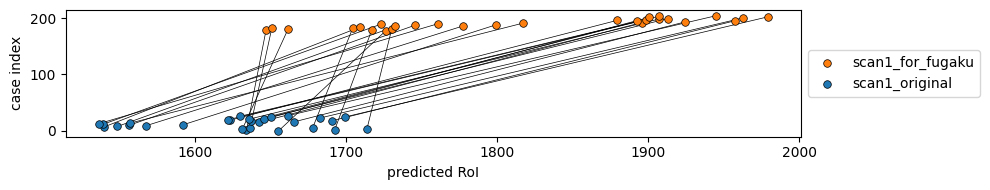

In [67]:
plt.figure(figsize=(10, 2))

case_space = 150
data_size = new_scan1_pred.shape[0]

x1 = new_y_pred_list[0]
x2 = new_scan1_pred[:,0]
y1 = list(range(data_size))
ys = np.max(y1) + case_space
y2 = list(range(ys, ys+data_size))

# 空調条件対応関係プロット
space = case_space + data_size - 1
for i in range(data_size):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], c='k', lw=0.5, zorder=1)

# RoIプロット
plt.scatter(x1, y1, marker='o', s=30, edgecolor='k', linewidth=0.5, label=f'scan1_original', zorder=2)
plt.scatter(x2, y2, marker='o', s=30, edgecolor='k', linewidth=0.5, label=f'scan1_for_fugaku', zorder=2)

plt.xlabel('predicted RoI')
plt.ylabel('case index')
# plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()